In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import gc

# dir_path = '/kaggle/input/riiid-test-answer-prediction/'
dir_path = '/home/zuoyuhui/datasets/riid准确回答/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from collections import Counter

In [3]:
nrows = 100 * 10000
train = pd.read_csv(
                    dir_path + file_train, 
                    nrows=nrows, 
                    usecols=['row_id', 'timestamp', 'user_id', 'content_id', 
                             'content_type_id', 'task_container_id', 'answered_correctly',
                            'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                            'row_id': 'int64',
                            'timestamp': 'int64',
                            'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'int8',
                            'task_container_id': 'int8',
                            'answered_correctly': 'int8',
                            'prior_question_elapsed_time': 'float32',
                            'prior_question_had_explanation': 'str'
                        }
                   )

lectures = pd.read_csv(
                       dir_path + file_lectures, 
                       usecols=['lecture_id','tag','part','type_of'], 
                       nrows=nrows,
                       dtype={
                           'lecture_id': 'int16',
                           'tag': 'int16',
                           'part': 'int8',
                           'type_of': 'str'
                       }
                    )

questions = pd.read_csv(
                        dir_path + file_questions, 
                        nrows=nrows,
                        usecols=['question_id','bundle_id','part','tags'], 
                        dtype={
                           'question_id': 'int16',
                           'bundle_id': 'int16',
                           'part': 'int8',
                           'tags': 'str'
                       }
                    )


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int32  
 3   content_id                      1000000 non-null  int16  
 4   content_type_id                 1000000 non-null  int8   
 5   task_container_id               1000000 non-null  int8   
 6   answered_correctly              1000000 non-null  int8   
 7   prior_question_elapsed_time     976277 non-null   float32
 8   prior_question_had_explanation  996184 non-null   object 
dtypes: float32(1), int16(1), int32(1), int64(2), int8(3), object(1)
memory usage: 35.3+ MB


In [5]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,1,NaN,NaN
1,1,56943,115,5716,0,2,1,37000.0,False
2,2,118363,115,128,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,1,19000.0,False
4,4,137965,115,7922,0,4,1,11000.0,False


In [6]:
# 数据处理
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].map({'True':1,'False':0}).fillna(-1).astype(np.int8)

In [7]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [8]:
Counter(lectures['type_of'])
lectures['type_of'] = lectures['type_of'].map({'concept':0, 'intention':1, 'solving question':2, 'starter':3}).fillna(-1).astype(np.int8)

In [9]:
questions.head()

,question_id,bundle_id,part,tags
0,0,0,1,51 131 162 38
1,1,1,1,131 36 81
2,2,2,1,131 101 162 92
3,3,3,1,131 149 162 29
4,4,4,1,131 5 162 38


In [10]:
questions['tags'] = questions['tags'].fillna('1')
questions['tags'] = questions['tags'].map(lambda x:len(str(x).split(' ')))

In [11]:
# 压缩内存
max_num = 1000
train = train.groupby(['user_id']).tail(max_num)# 每个’user_id' 大于一千条

In [12]:
# 切分数据
train_lectures = train[train['content_type_id']==1]
train_questions = train[train['content_type_id']==0]
del train
gc.collect()

88

In [13]:
# 关联数据
train_lectures_info = pd.merge(
        left=train_lectures,
        right=lectures,
        how='left',
        left_on='content_id',
        right_on='lecture_id'
        )

train_question_info = pd.merge(
        left=train_questions,
        right=questions,
        how='left',
        left_on='content_id',
        right_on='question_id'
        )

In [14]:
del train_lectures
del train_questions
gc.collect()

44

In [15]:
train_lectures_info

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,part,type_of
0,89,653762,2746,6808,1,14,-1,NaN,0,6808,129,2,1
1,117,10183847,5382,16736,1,21,-1,NaN,0,16736,40,1,0
2,212,1424348597,5382,30207,1,104,-1,NaN,0,30207,43,5,0
3,216,1425557777,5382,18545,1,121,-1,NaN,0,18545,58,5,0
4,295,405813029,8623,10540,1,59,-1,NaN,0,10540,99,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12848,999740,206141912,20938253,14443,1,30,-1,NaN,0,14443,28,5,0
12849,999746,206253699,20938253,21597,1,36,-1,NaN,0,21597,116,5,0
12850,999762,207265143,20938253,26404,1,52,-1,NaN,0,26404,52,5,2
12851,999790,208152685,20938253,22362,1,80,-1,NaN,0,22362,73,5,0


In [16]:
gb_columns = ['task_id','part']

In [17]:
# 提取特征函数
# 文献课程类函数
def get_lecture_basic_features__user(train_lectures_info):
    gb_columns=['user_id']
    gb_suffixes = 'lecture_'+'_'.join(gb_columns)
    
    agg_func = {
        'lecture_id':[np.size,np.sum],
        'task_container_id':[lambda x:len(set(x))],
#         'tag':[lambda x:len(set(x))],
        # part 展开
        'part':[lambda x:len(set(x))],
        #type_of 展开
        'type_of':[lambda x:len(set(x))]
    }
    
    columns = [
        gb_suffixes+'_size_lecture_id',
        gb_suffixes+'_sum_lecture_id',
        gb_suffixes+'_unique_task_container_id',
#         gb_suffixes+'_unique_tag',
        gb_suffixes+'_unique_part',
        gb_suffixes+'_unique_type_of'
    ]
    train_lectures_info_user_f = train_lectures_info.groupby(gb_columns).agg(agg_func).reset_index()
    train_lectures_info_user_f.columns = gb_columns+columns
    return train_lectures_info_user_f

In [18]:
def get_lecture_basic_feature__user_tag(train_lectures_info):
    gb_columns = ['user_id','tag']
    gb_suffixes = 'lecture_'+'_'.join(gb_columns)
    
    agg_func = {
        'lecture_id':[np.size,np.sum],
        'task_container_id':[lambda x:len(set(x))],
#         'tag':[lambda x:len(set(x))],
        'part':[lambda x:len(set(x))],
    }
    columns =[
        gb_suffixes+'_size_lecture_id', 
        gb_suffixes+'_sum_lecture_id',
        gb_suffixes+'_unique_task_container_id',
#         gb_suffixes+'_unique_tag',
        gb_suffixes+'_unique_part'
    ]
    train_lectures_info__user_tag_f = train_lectures_info.groupby(gb_columns).agg(agg_func).reset_index()
    train_lectures_info__user_tag_f.columns = gb_columns+columns
    return train_lectures_info__user_tag_f

In [19]:
# type(train_question_info['tags'].values) # numpy.ndarray
# for  i in train_question_info['tags'].values:
#     print(len(set(i)))

In [20]:
# 问答类
def get_questions_basic_features__user(train_question_info):
    gb_columns = ['user_id']
    gb_suffixes = 'question_'+'_'.join(gb_columns)
    
    agg_func = {
        'answered_correctly':[np.mean,np.sum,np.std,np.min],
        'question_id':[np.size],
        'task_container_id':[lambda x:len(set(x))],
        'prior_question_elapsed_time':[np.mean,np.max,np.min],
        'prior_question_had_explanation':[lambda x:len(set(x))],
        'bundle_id':[lambda x:len(set(x))],
#         'part':[lambda x:len(set(x))],
#         'tags':[lambda x:len(x)]
    }
    columns =[
        gb_suffixes+'_answered_correctly_mean',
        gb_suffixes+'_answered_correctly_sum',
        gb_suffixes+'_answered_correctly_std',
#         gb_suffixes+'_answered_correctly_max',
        gb_suffixes+'_answered_correctly_min',
        
        gb_suffixes+'_size_question_id',
        gb_suffixes+'_unique_task_container_id',
        gb_suffixes+'_prior_question_elapsed_time_mean',
        gb_suffixes+'_prior_question_elapsed_time_max',
        gb_suffixes+'_prior_question_elapsed_time_min',

        gb_suffixes+'_unique_prior_question_had_explanation',

        gb_suffixes+'_unique_bundle_id',
#         gb_suffixes+'_unique_part',
#         gb_suffixes+'_unique_tags',
    ]
    train_question_info__user_f = train_question_info.groupby(gb_columns).agg(agg_func).reset_index()
    train_question_info__user_f.columns = gb_columns+columns
    return train_question_info__user_f

In [21]:
def get_questions_basic_features__user_part(train_question_info):
    gb_columns = ['user_id','part']
    gb_suffixes = 'question_'+'_'.join(gb_columns)
    agg_func = {
        'answered_correctly': [np.mean,np.sum,np.std,np.min],

        'question_id': [np.size],
        'task_container_id': [lambda x: len(set(x))],

        'prior_question_elapsed_time': [np.mean,np.max,np.min],

        'prior_question_had_explanation': [lambda x: len(set(x))],

        'bundle_id': [lambda x: len(set(x))],

        # part 展开
#         'part': [lambda x: len(set(x))],
#         'tags': [lambda x: len(x)],
    }
    columns = [
        gb_suffixes+'_answered_correctly_mean',
        gb_suffixes+'_answered_correctly_sum',
        gb_suffixes+'_answered_correctly_std',
#         gb_suffixes+'_answered_correctly_max',
        gb_suffixes+'_answered_correctly_min',

        gb_suffixes+'_size_question_id', 
        gb_suffixes+'_unique_task_container_id',
        gb_suffixes+'_prior_question_elapsed_time_mean',
        gb_suffixes+'_prior_question_elapsed_time_max',
        gb_suffixes+'_prior_question_elapsed_time_min',

        gb_suffixes+'_unique_prior_question_had_explanation',

        gb_suffixes+'_unique_bundle_id',
#         gb_suffixes+'_unique_part',
#         gb_suffixes+'_unique_tags',
    ]
    train_questions_info__user_part_f = train_question_info.groupby(gb_columns).agg(agg_func).reset_index()
    train_questions_info__user_part_f.columns = gb_columns+columns
    return train_questions_info__user_part_f

In [22]:
def get_questions_basic_features__content(train_question_info):
    gb_columns = ['content_id']
    gb_suffixes = 'question_'+'_'.join(gb_columns)
    agg_func = {
        'answered_correctly':[np.mean,np.sum,np.std,np.min],
        'user_id':[np.size],
        'prior_question_elapsed_time':[np.mean,np.max,np.min],
        'prior_question_had_explanation':[lambda x:len(set(x))]
    }
    columns = [
        gb_suffixes+'_answered_correctly_mean',
        gb_suffixes+'_answered_correctly_sum',
        gb_suffixes+'_answered_correctly_std',
#         gb_suffixes+'_answered_correctly_max',
        gb_suffixes+'_answered_correctly_min',

        gb_suffixes+'_size_user_id', 
        gb_suffixes+'_prior_question_elapsed_time_mean',
        gb_suffixes+'_prior_question_elapsed_time_max',
        gb_suffixes+'_prior_question_elapsed_time_min',

        gb_suffixes+'_unique_prior_question_had_explanation',
    ]
    train_questions_info__user_content_f = train_question_info.groupby(gb_columns).agg(agg_func).reset_index()
    train_questions_info__user_content_f.columns=gb_columns+columns
    return train_questions_info__user_content_f

In [23]:
# 预测用户
# test_lectures_info__user_f = get_lecture_basic_features__user(train_lectures_info)
# # test_lectures_info__user_tag_f = get_lecture_basic_feature__user_tag(train_lectures_info)

# test_questions_info__user_f = get_questions_basic_features__user(train_question_info)
# # test_questions_info__user_part_f = get_questions_basic_features__user_part(train_question_info)

# test_questions_info__user_content_f = get_questions_basic_features__content(train_question_info)

test_lectures_info__user_f = get_lecture_basic_features__user(train_lectures_info)
# test_lectures_info__user_tag_f = get_lecture_basic_features__user_tag(train_lectures_info)
test_questions_info__user_f = get_questions_basic_features__user(train_question_info)
# test_questions_info__user_part_f = get_questions_basic_features__user_part(train_questions_info)
test_questions_info__user_content_f = get_questions_basic_features__content(train_question_info)

In [24]:
# test_lectures_info__user_f['lecture_user_id_unique_tag']

In [25]:
# 验证数据
valid_data = pd.DataFrame()
for i in range(6):
    # 获取训练标签数据
    last_records = train_question_info.drop_duplicates('user_id',keep='last')
    
    # 获取训练标签以前的数据
    map__last_record__user_row = dict(zip(last_records['user_id'],last_records['row_id']))
    
    train_question_info['filter_row'] = train_question_info['user_id'].map(map__last_record__user_row)
    train_lectures_info['filter_row'] = train_lectures_info['user_id'].map(map__last_record__user_row)
    
    train_question_info = train_question_info[train_question_info['row_id'] < train_question_info['filter_row']]
    train_lectures_info = train_lectures_info[train_lectures_info['row_id'] < train_lectures_info['filter_row']]
    
    # 获取特征
    train_lectures_info__user_f = get_lecture_basic_features__user(train_lectures_info)
#     train_lectures_info__user_tag_f = get_lecture_basic_feature__user_tag(train_lectures_info)
    train_questions_info__user_f = get_questions_basic_features__user(train_question_info)
#     train_questions_info__user_part_f = get_questions_basic_features__user_part(train_question_info)
    train_questions_info__user_content_f = get_questions_basic_features__content(train_question_info)
    
    last_records = last_records.merge(train_lectures_info__user_f, on=['user_id'], how='left')
#     last_records = last_records.merge(train_lectures_info__user_tag_f,on=['user_id'], how='left')
    last_records = last_records.merge(train_questions_info__user_f,on=['user_id'], how='left')
#     last_records = last_records.merge(train_questions_info__user_part_f, on=['user_id'],how='left')
    last_records = last_records.merge(train_questions_info__user_content_f, on=['content_id'], how='left')
    
    #特征加入训练集
    valid_data = valid_data.append(last_records)
    print(len(valid_data))


# valid_data = pd.DataFrame()

# for i in range(6):
    
#     # 获取训练标签数据
#     last_records = train_question_info.drop_duplicates('user_id', keep='last')
    
#     # 获取训练标签以前的数据
#     map__last_records__user_row = dict(zip(last_records['user_id'],last_records['row_id']))
    
#     train_question_info['filter_row'] = train_question_info['user_id'].map(map__last_records__user_row)
#     train_lectures_info['filter_row'] = train_lectures_info['user_id'].map(map__last_records__user_row)

#     train_questions_info = train_question_info[train_question_info['row_id']<train_question_info['filter_row']]
#     train_lectures_info = train_lectures_info[train_lectures_info['row_id']<train_lectures_info['filter_row']]
    
#     # 获取特征
#     train_lectures_info__user_f = get_lecture_basic_features__user(train_lectures_info)
#     # train_lectures_info__user_tag_f = get_lecture_basic_features__user_tag(train_lectures_info)
#     train_questions_info__user_f = get_questions_basic_features__user(train_question_info)
#     # train_questions_info__user_part_f = get_questions_basic_features__user_part(train_questions_info)
#     train_questions_info__user_content_f = get_questions_basic_features__content(train_question_info)

#     last_records = last_records.merge(train_lectures_info__user_f,on=['user_id'],how='left')
#     last_records = last_records.merge(train_questions_info__user_f,on=['user_id'],how='left')
#     last_records = last_records.merge(train_questions_info__user_content_f,on=['content_id'],how='left')
    
#     # 特征加入训练集
#     valid_data = valid_data.append(last_records)
#     print(len(valid_data))

3824
7646
11466
15285
19104
22923


In [26]:
# 训练数据集
train_data = pd.DataFrame()
for i in range(10):
    
    # 获取训练标签数据
    last_records = train_question_info.drop_duplicates('user_id',keep='last')
    # 获取训练标签以前的数据
    map__last_records__user_row = dict(zip(last_records['user_id'],last_records['row_id']))
    
    train_question_info['filter_row'] = train_question_info['user_id'].map(map__last_records__user_row)
    train_lectures_info['filter_row'] = train_lectures_info['user_id'].map(map__last_records__user_row)
    
    train_question_info = train_question_info[train_question_info['row_id'] < train_question_info['filter_row']]
    train_lectures_info = train_lectures_info[train_lectures_info['row_id'] < train_lectures_info['filter_row']]
    
    #获取特征
    train_lectures_info__user_f = get_lecture_basic_features__user(train_lectures_info)
#     train_lectures_info__user_tag_f = get_lecture_basic_feature__user_tag(train_lectures_info)
    train_questions_info__user_f = get_questions_basic_features__user(train_question_info)
#     train_questions_info__user_part_f = get_questions_basic_features__user_part(train_question_info)
    train_questions_info__user_content_f = get_questions_basic_features__content(train_question_info)
    
    last_records = last_records.merge(train_lectures_info__user_f, on=['user_id'], how='left')
#     last_records = last_records.merge(train_lectures_info__user_tag_f,on=['user_id'], how='left')
    last_records = last_records.merge(train_questions_info__user_f,on=['user_id'], how='left')
#     last_records = last_records.merge(train_questions_info__user_part_f, on=['user_id'],how='left')
    last_records = last_records.merge(train_questions_info__user_content_f, on=['content_id'], how='left')
    
    # 特征加入训练集
    train_data = train_data.append(last_records)
    print(len(train_data))

# 训练数据
# train_data = pd.DataFrame()

# for i in range(10):
    
#     # 获取训练标签数据
#     last_records = train_question_info.drop_duplicates('user_id', keep='last')
    
#     # 获取训练标签以前的数据
#     map__last_records__user_row = dict(zip(last_records['user_id'],last_records['row_id']))
    
#     train_question_info['filter_row'] = train_question_info['user_id'].map(map__last_records__user_row)
#     train_lectures_info['filter_row'] = train_lectures_info['user_id'].map(map__last_records__user_row)

#     train_questions_info = train_question_info[train_question_info['row_id']<train_question_info['filter_row']]
#     train_lectures_info = train_lectures_info[train_lectures_info['row_id']<train_lectures_info['filter_row']]
    
#     # 获取特征
#     train_lectures_info__user_f = get_lecture_basic_features__user(train_lectures_info)
#     # train_lectures_info__user_tag_f = get_lecture_basic_features__user_tag(train_lectures_info)
#     train_questions_info__user_f = get_questions_basic_features__user(train_question_info)
#     # train_questions_info__user_part_f = get_questions_basic_features__user_part(train_questions_info)
#     train_questions_info__user_content_f = get_questions_basic_features__content(train_question_info)

#     last_records = last_records.merge(train_lectures_info__user_f,on=['user_id'],how='left')
#     last_records = last_records.merge(train_questions_info__user_f,on=['user_id'],how='left')
#     last_records = last_records.merge(train_questions_info__user_content_f,on=['content_id'],how='left')
    
#     # 特征加入训练集
#     train_data = train_data.append(last_records)
#     print(len(train_data))

3819
7626
11432
15236
19034
22819
26539
30175
33770
37352


In [27]:
# 修改
remove_columns = ['user_id','row_id','content_type_id','user_answer','answered_correctly','filter_row']
features_columns = [c for c in train_data.columns if c not in remove_columns]

In [28]:
# train_data[features_columns + ['answered_correctly']].corr()

Text(0.5, 1086.8937499999997, 'columns_b')

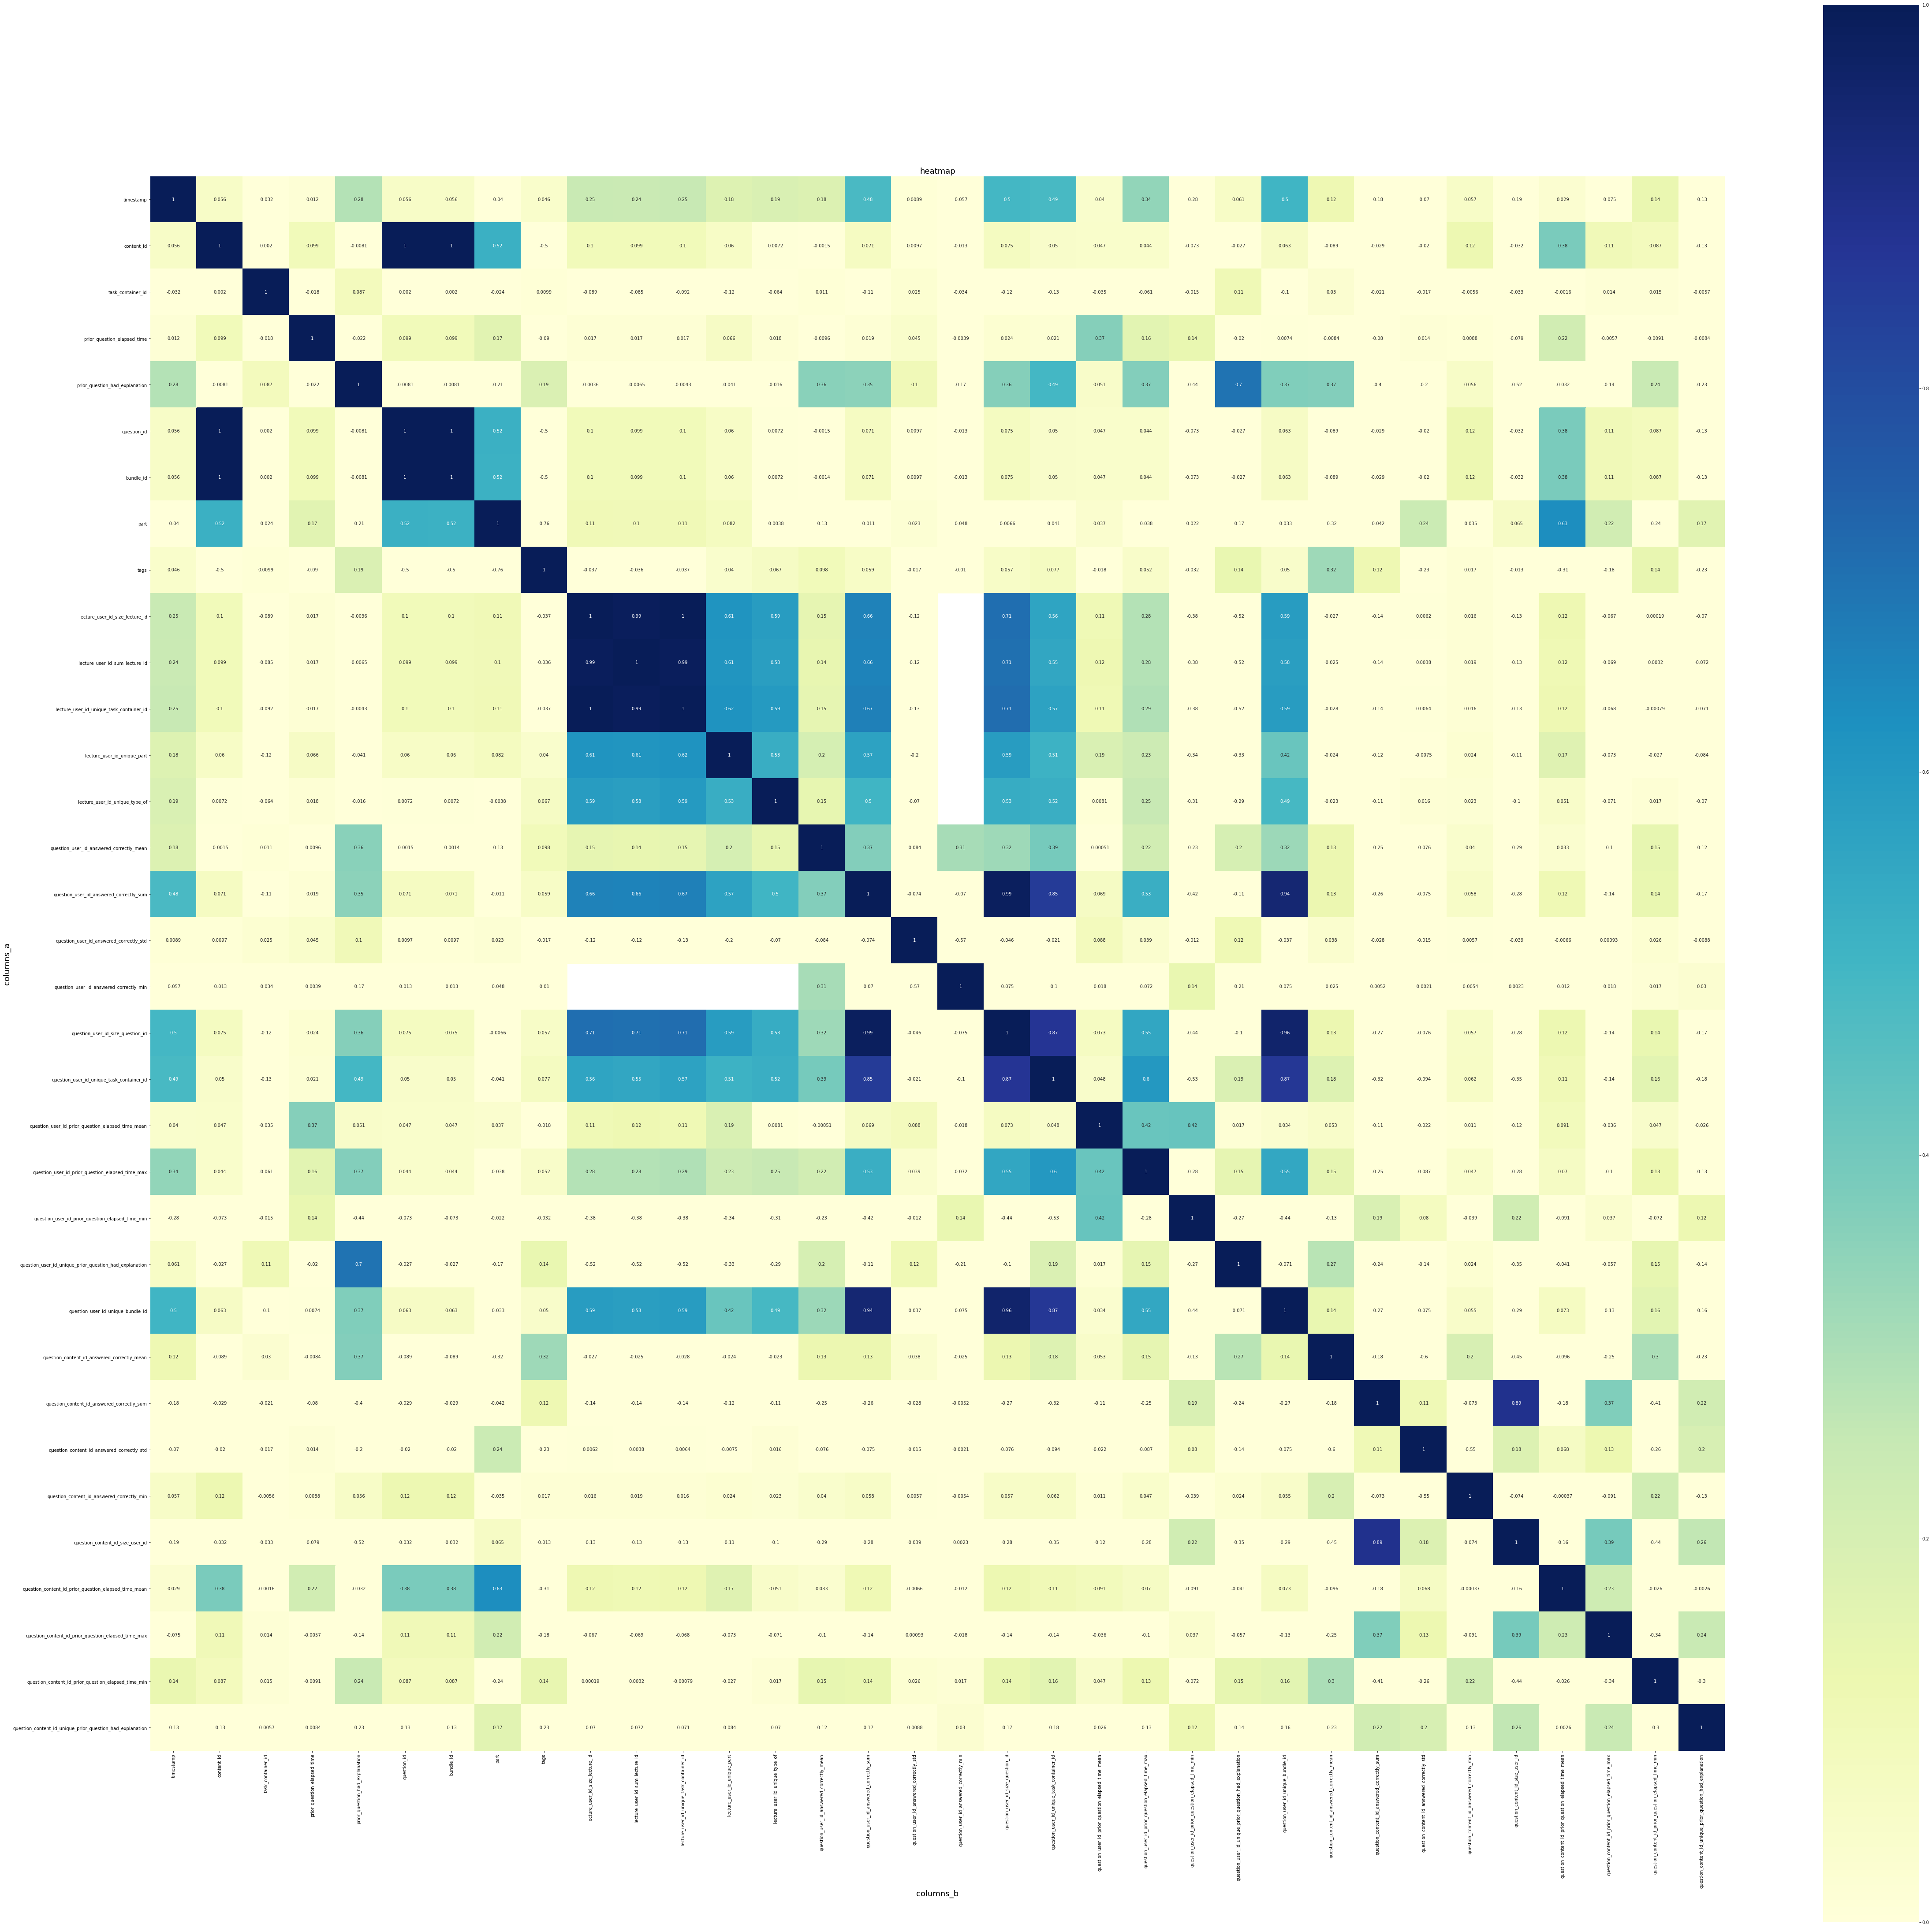

In [29]:
fig, ax = plt.subplots(figsize=(80,80))
sns.heatmap(train_data[features_columns].corr(),
           annot=True, vmax=1, vmin=0, xticklabels=True, yticklabels=True, square=True, cmap='YlGnBu')
ax.set_title('heatmap', fontsize = 18)
ax.set_ylabel('columns_a', fontsize = 18)
ax.set_xlabel('columns_b', fontsize = 18) 

In [30]:
#question_user_id_answered_correctly_max
# valid_data.drop(['question_user_id_answered_correctly_max'],inplace=True,axis=1)
# train_data.drop(['question_user_id_answered_correctly_max'],inplace=True,axis=1)

In [31]:
# 特征重要性
X_test, y_test = valid_data[features_columns].values, valid_data['answered_correctly'].values

X_train, y_train = train_data[features_columns].values, train_data['answered_correctly'].values

In [32]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 9,
    'learning_rate': 0.3,
    'feature_fraction_seed': 2,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data': 20,
    'min_hessian': 1,
    'verbose': -1,
    'silent': 0
    }

lgb_train =lgb.Dataset(X_train,y_train)
lgb_eval = lgb.Dataset(X_test,y_test,reference=lgb_train)

gbm = lgb.train(params,
               lgb_train,
               num_boost_round=10000,
               valid_sets=lgb_eval,
               early_stopping_rounds=20)

[LightGBM] [Warning] Unknown parameter: silent
[1]	valid_0's auc: 0.695261
Training until validation scores don't improve for 20 rounds
[2]	valid_0's auc: 0.707364
[3]	valid_0's auc: 0.709082
[4]	valid_0's auc: 0.710595
[5]	valid_0's auc: 0.712667
[6]	valid_0's auc: 0.71295
[7]	valid_0's auc: 0.71287
[8]	valid_0's auc: 0.714518
[9]	valid_0's auc: 0.715712
[10]	valid_0's auc: 0.716726
[11]	valid_0's auc: 0.717034
[12]	valid_0's auc: 0.717551
[13]	valid_0's auc: 0.717595
[14]	valid_0's auc: 0.718402
[15]	valid_0's auc: 0.718693
[16]	valid_0's auc: 0.718718
[17]	valid_0's auc: 0.718985
[18]	valid_0's auc: 0.719192
[19]	valid_0's auc: 0.719249
[20]	valid_0's auc: 0.719092
[21]	valid_0's auc: 0.718891
[22]	valid_0's auc: 0.718927
[23]	valid_0's auc: 0.719055
[24]	valid_0's auc: 0.71962
[25]	valid_0's auc: 0.719707
[26]	valid_0's auc: 0.719878
[27]	valid_0's auc: 0.719779
[28]	valid_0's auc: 0.720121
[29]	valid_0's auc: 0.720267
[30]	valid_0's auc: 0.720144
[31]	valid_0's auc: 0.720873
[32]	

In [33]:
gbm.feature_importance()

array([ 9, 10,  6, 17,  0,  0,  3,  0,  1,  2,  6,  1,  4,  0, 34,  9, 21,
        0,  5,  4, 15,  3,  9,  1, 10, 29, 18, 21,  0, 10, 10,  9,  4,  1],
      dtype=int32)

In [34]:
len(features_columns)

34

In [35]:
gbm_features = pd.DataFrame({'feature_importance':gbm.feature_importance(),'features_columns':features_columns}).sort_values(['feature_importance'],ascending=0)
gbm_features

,feature_importance,features_columns
14,34,question_user_id_answered_correctly_mean
25,29,question_content_id_answered_correctly_mean
16,21,question_user_id_answered_correctly_std
27,21,question_content_id_answered_correctly_std
26,18,question_content_id_answered_correctly_sum
3,17,prior_question_elapsed_time
20,15,question_user_id_prior_question_elapsed_time_mean
1,10,content_id
30,10,question_content_id_prior_question_elapsed_tim...
29,10,question_content_id_size_user_id


Text(0.5, 1.0, 'Featurertances')

<Figure size 7200x7200 with 0 Axes>

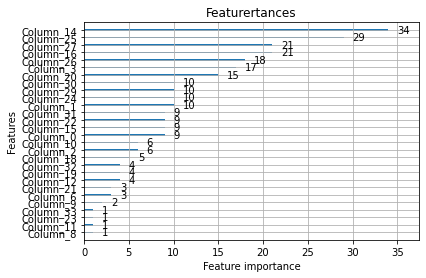

In [36]:
plt.figure(figsize=(100,100))
lgb.plot_importance(gbm,max_num_features=30)
plt.title("Featurertances")

In [38]:
X_test, y_test = valid_data[features_columns].values, valid_data['answered_correctly'].values
X_train, y_train = train_data[features_columns].values, train_data['answered_correctly'].values

In [28]:
import riiideducation
env = riiideducation.make_env()
iter_test = env.iter_test()

ModuleNotFoundError: No module named 'riiideducation'

In [30]:
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
	test_df = pd.merge(test_df, results_u_final, on=['user_id'],  how="left")
	test_df = pd.merge(test_df, results_c_final, on=['content_id'],  how="left")
	test_df = pd.merge(test_df, results_ut_final, on=['user_id'],  how="left")
	test_df = pd.merge(test_df, results_ct_final, on=['content_id'],  how="left")

    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df["prior_question_had_explanation_enc"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])

    X_test = test_df[columns_features]
    X_test.fillna(-1, inplace=True)

    test_df['answered_correctly'] =  model.predict(X_test)
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 9)